In [1]:
import sys
import os
sys.path.insert(1, '/cmlscratch/xic/FairRL/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# for smoothing
from scipy.ndimage.filters import gaussian_filter1d

/tmp/ipykernel_3623855/2378886784.py:9: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [5]:

def plot_return_bias(exp_path, save=True, smooth=-1):
    
    # read data
    data_pth  = os.path.join(exp_path,'eval.csv') 
    data_pth  = os.path.join(exp_path,'eval.csv') 
    data = pd.read_csv(data_pth, sep=',', header=0)
    
    # to numpy
    num_samples = data['num_timesteps'].to_numpy()

    return_arr = data['return'].to_numpy() # this is the reward averaged across timesteps and episodes, as in attention_allocation_experiment.agents.ppo.sb3.utils_fair
    benefit_max = data['benefit_max'].to_numpy()
    benefit_min = data['benefit_min'].to_numpy()
    bias = data['bias'].to_numpy()
    
    if smooth > 0:
        return_arr = gaussian_filter1d(return_arr, sigma=smooth)
        benefit_max = gaussian_filter1d(benefit_max, sigma=smooth)
        benefit_min = gaussian_filter1d(benefit_min, sigma=smooth)
        bias = gaussian_filter1d(bias, sigma=smooth)
    
    # plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (8,8), sharex=True)
    # fig, (ax1, ax3) = plt.subplots(2, figsize = (8,8), sharex=True)
    fig.suptitle('exp path: {}'.format(exp_path))
    # return
    ax1.plot(num_samples,return_arr)
    ax1.set_ylim(-0.1, 0.21)
    ax1.set_ylabel('return')
    ax1.set_title('average return / episode_len')
#     ax1.set_ylim(0.1,0.6)
    ax1.grid()
    # benefit
    ax2.plot(num_samples,benefit_max,label='benefit_max')
    ax2.plot(num_samples,benefit_min,label='benefit_min')
    ax2.legend()
    ax2.set_ylabel('benefit')
    ax2.set_title('benefit max and min')
    # bias
    ax3.plot(num_samples,bias)
    ax3.set_xlabel('Samples')
    ax3.set_ylabel('Bias')
    ax3.axhline(y=0, color='r', linestyle='-')
    ax3.set_title('Bias')
    ax3.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#     ax3.set_ylim(-0.05,0.2)
    ax3.grid()
    if save:
        fig.savefig(os.path.join(EXP_DIR,exp_path,'result.png'))
    else:
        fig.show()

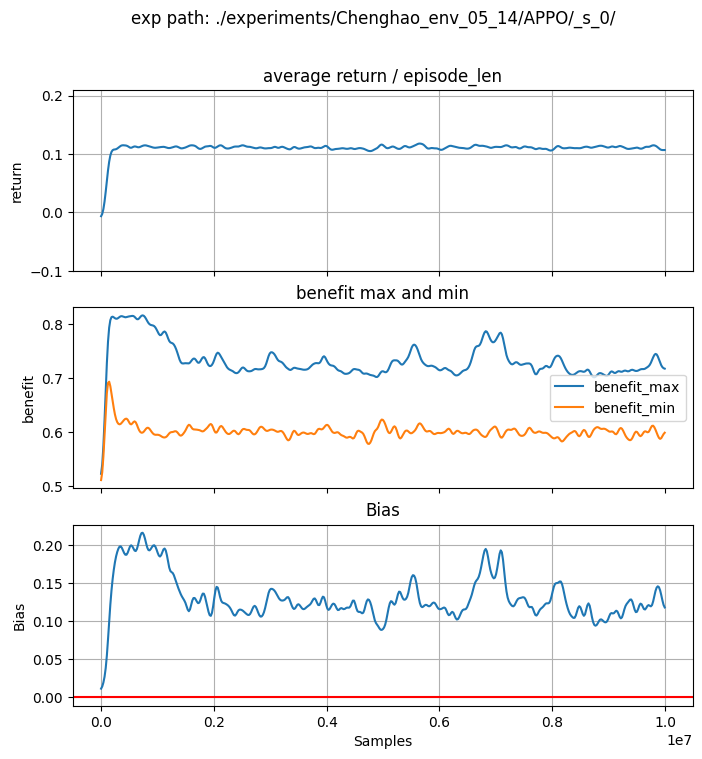

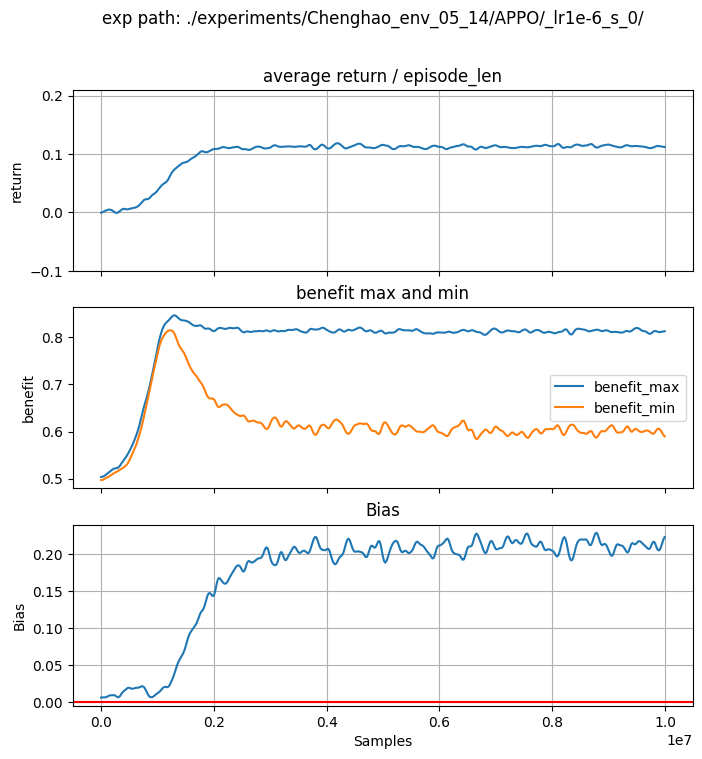

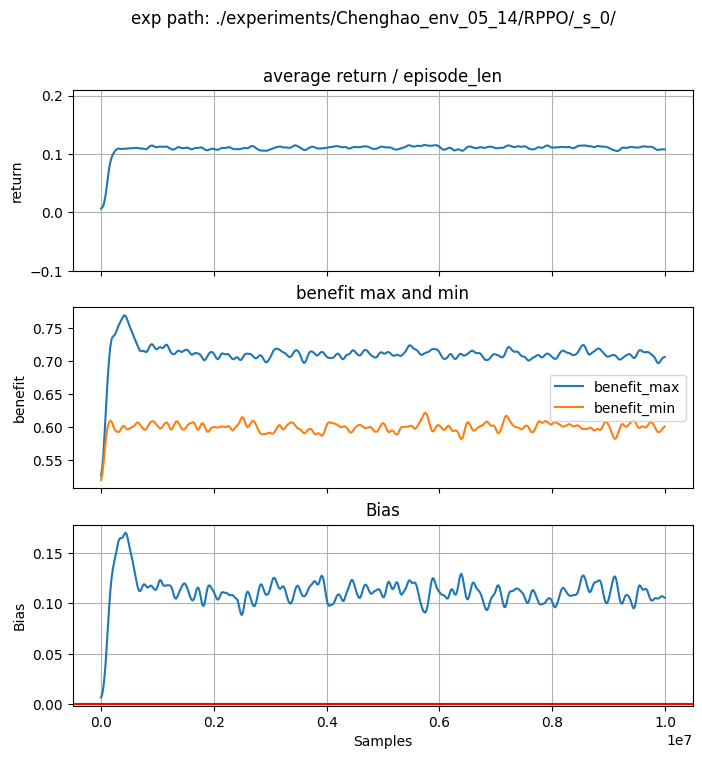

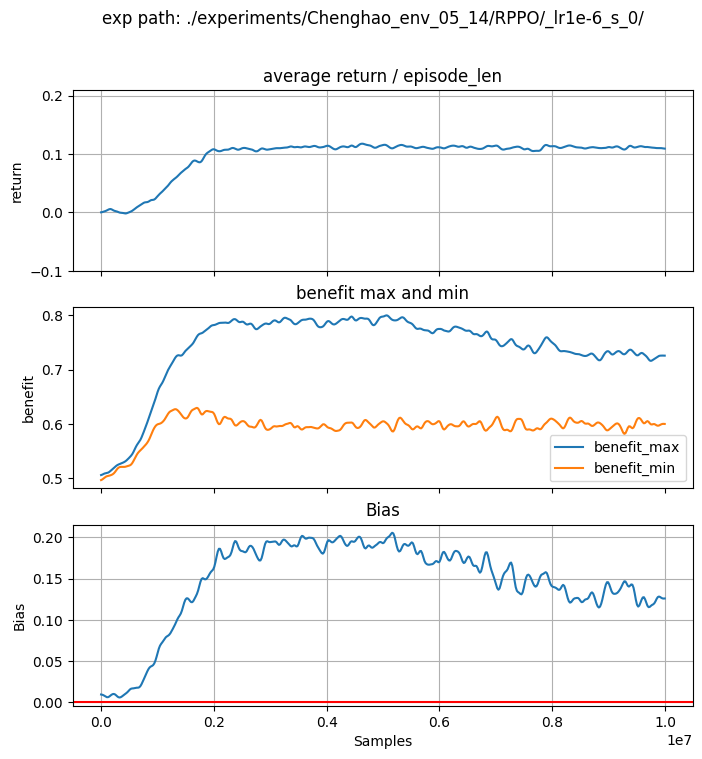

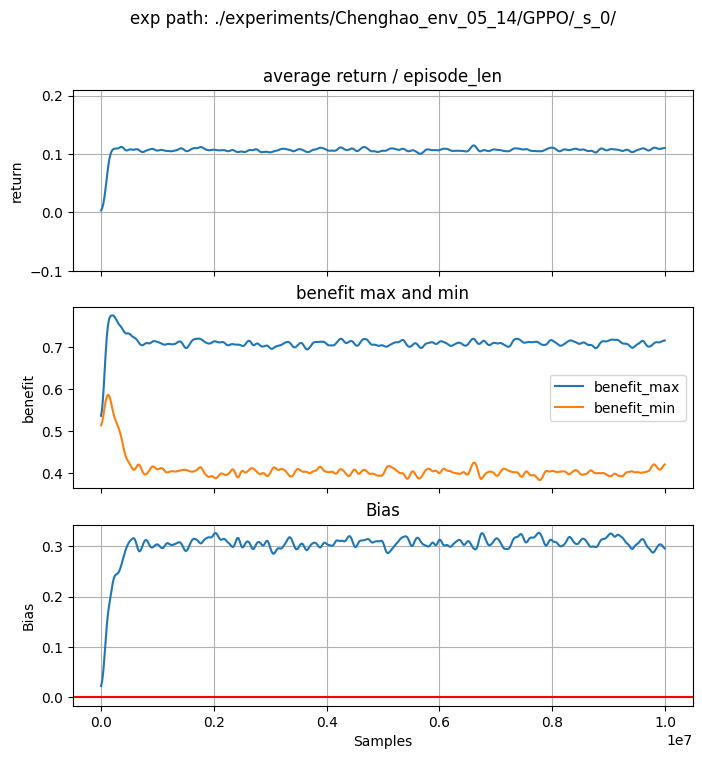

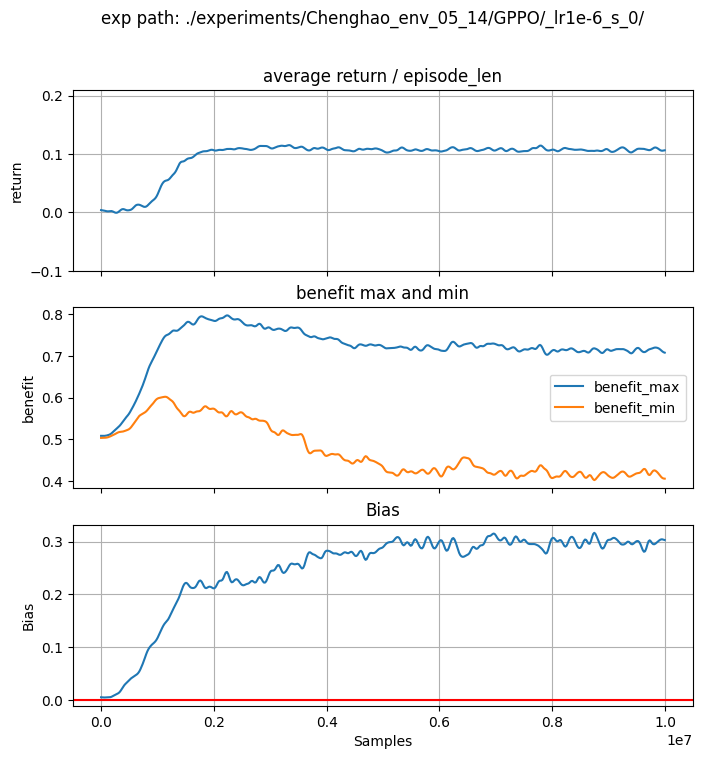

In [8]:
seed = 0
method_list = ['APPO','RPPO','GPPO']

for method in method_list:
      exp_path_base = './experiments/Chenghao_env_05_14/{}/_s_{}/'.format(method,seed)
      plot_return_bias(exp_path_base,save=False, smooth = 2)

      exp_path_base = './experiments/Chenghao_env_05_14/{}/_lr1e-6_s_{}/'.format(method,seed)
      plot_return_bias(exp_path_base,save=False, smooth = 2)

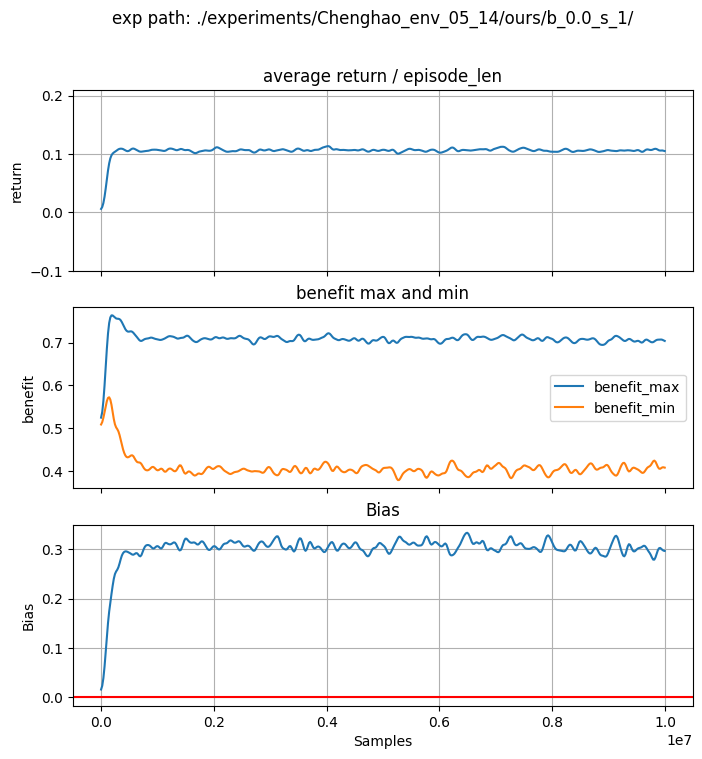

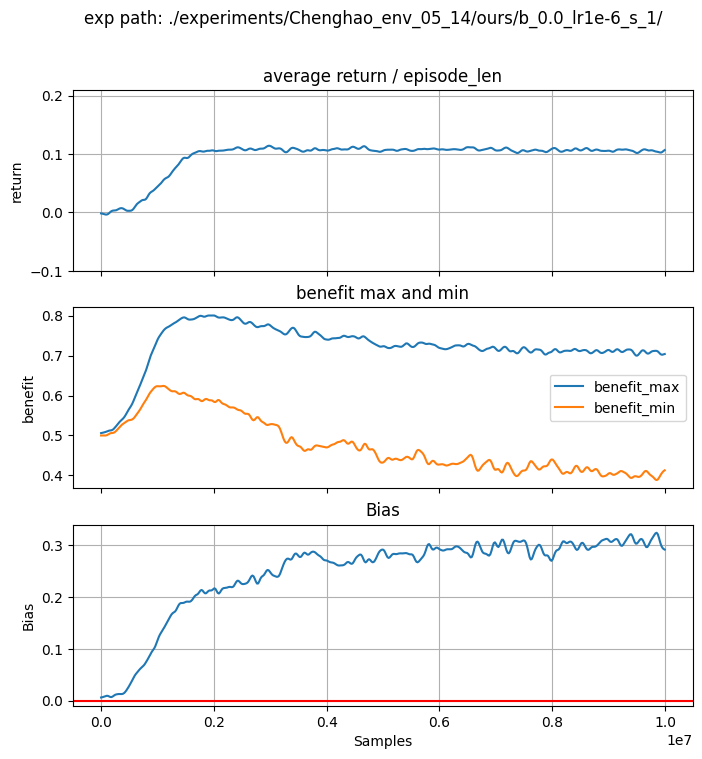

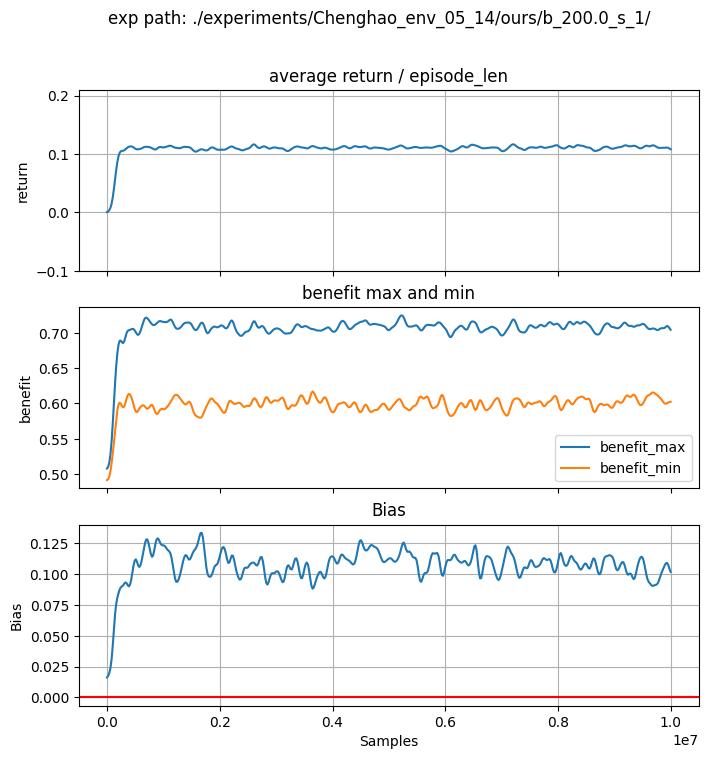

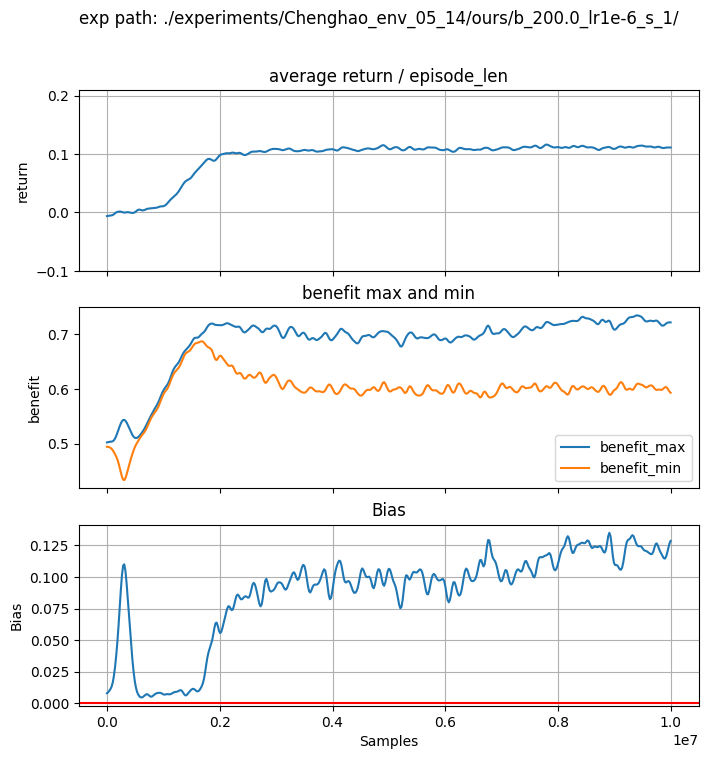

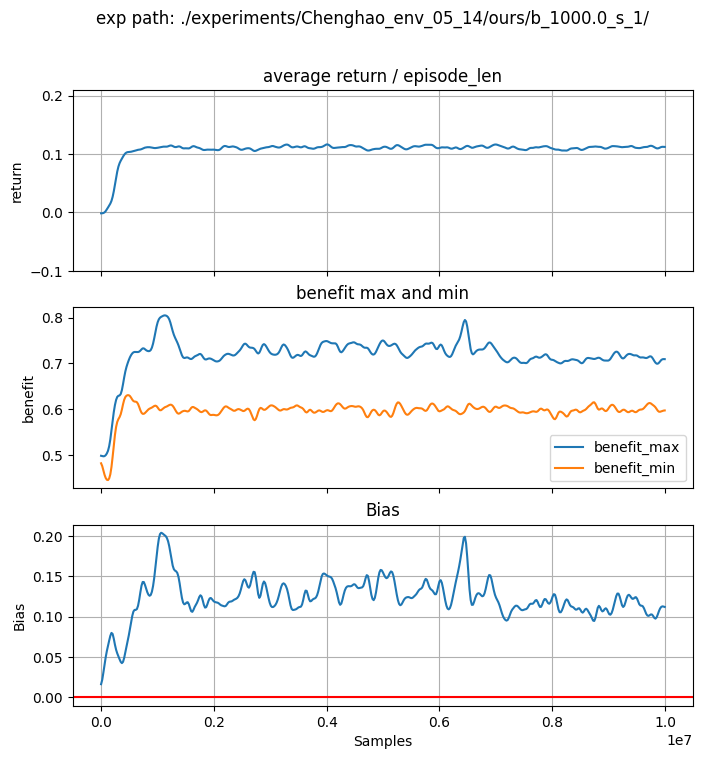

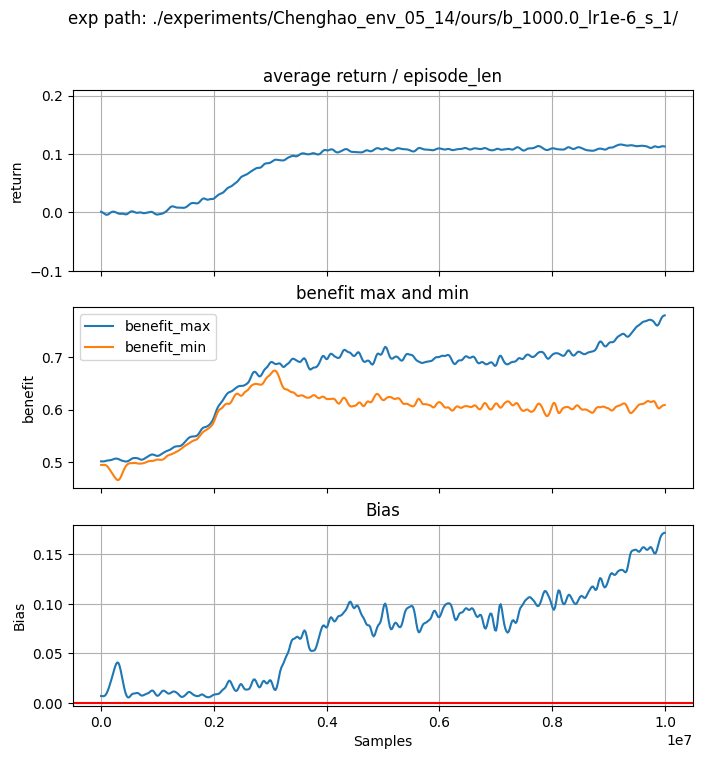

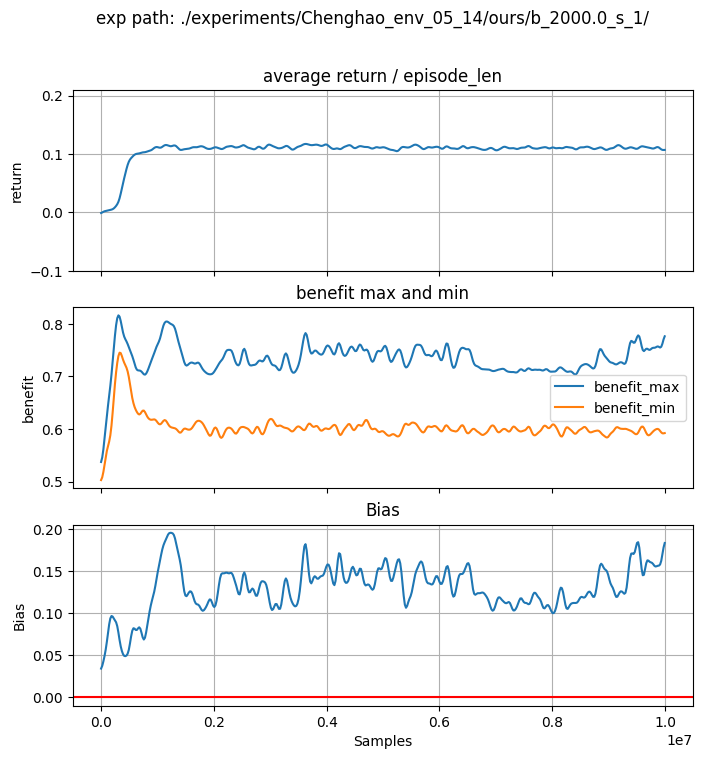

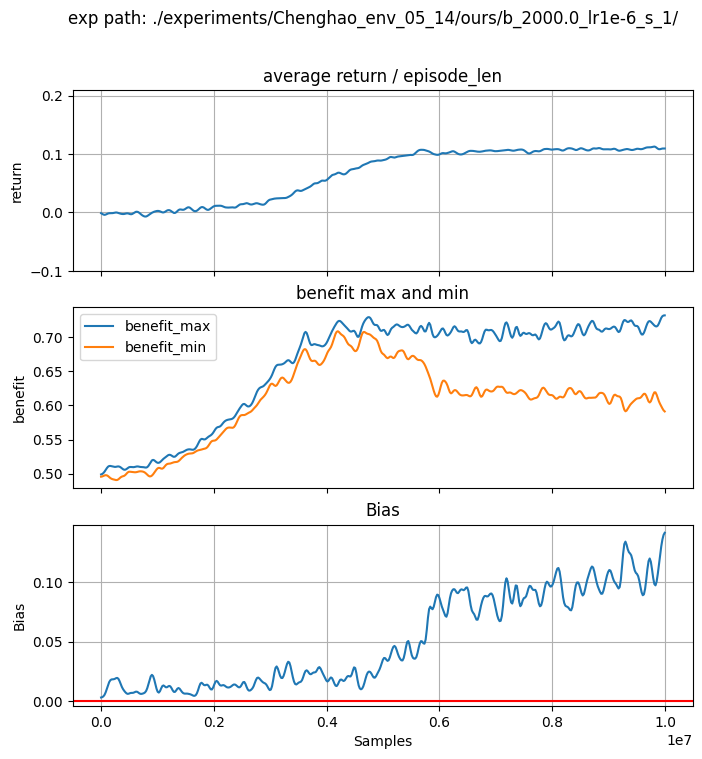

In [10]:
seed = 1
b_list = [0,200,1000,2000]

for b in b_list:
      exp_path_base = './experiments/Chenghao_env_05_14/ours/b_{}.0_s_{}/'.format(b,seed)
      plot_return_bias(exp_path_base,save=False, smooth = 2)

      exp_path_base = './experiments/Chenghao_env_05_14/ours/b_{}.0_lr1e-6_s_{}/'.format(b,seed)
      plot_return_bias(exp_path_base,save=False, smooth = 2)